In [1]:
import re
import string
from pyvi import ViTokenizer
import os
import numpy as np
from scipy.stats import entropy
import sqlite3
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

con = sqlite3.connect('../../instance/recommend_system.sqlite')
db_env = con.cursor()

stopwords_path = './vietnamese-stopword-dash.txt'
save_path = './models'
PATH_LDA_MODEL = f'{save_path}/LDA.model'
PATH_CORPUS = f'{save_path}/CORPUS.mm'
PATH_TOPICS_DOCS_DIST = f'{save_path}/topics_docs_dist.dat'
PATH_DICTIONARY = f'{save_path}/id2word.dictionary'

def jensen_shannon(doc_distribute, matrix_distribute):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M (the number of documents in the corpus)
    """
    p = doc_distribute[None, :].T
    q = matrix_distribute.T
    m = .5 * (p + q)
    return np.sqrt(.5 * (entropy(q, m) + entropy(p, m)))

def get_most_similar_news(doc_distribute, matrix_distribute, k=10):
    """
    This function implements the Jensen-Shannon distance above
    and returns the top k indices of the smallest jensen shannon distances
    """
    # List of jensen-shannon distances
    sims = jensen_shannon(doc_distribute=doc_distribute, matrix_distribute=matrix_distribute)

    # return index of most K similar distribution from list
    return np.argsort(sims)[:k]

def stopwords(text_file_path=stopwords_path):
    _stopwords = list(open(text_file_path, encoding='utf8').read().split())
    return _stopwords

_stopwords_default = stopwords()
def remove_stopwords(text, stopwords=_stopwords_default):
    return [word for word in text.split() if word not in stopwords]

def remove_numeric(text):
    table = str.maketrans({key: None for key in string.digits})
    return text.translate(table)

def remove_emails(text):
    return re.sub('\S*@\S*\s?', '', text)

def remove_links(text):
    return re.sub(r"http\S+", "", text)

def remove_multiple_whitespace(text):
    return re.sub("\s\s+", " ", text)

def remove_newline_characters(text):
    return re.sub('\n', ' ', text)

def remove_punctuation(text):
    """https://stackoverflow.com/a/37221663"""
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)

def vi_tokenizer(text):
    return ViTokenizer.tokenize(text)

def simple_preprocessing(text):
    _text = remove_newline_characters(text.lower())
    _text = remove_emails(_text)
    _text = remove_links(_text)
    _text = remove_numeric(_text)
    _text = remove_punctuation(_text)
    _text = remove_multiple_whitespace(_text)
    _text = vi_tokenizer(_text)
    _text = remove_stopwords(_text)
    return _text

c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\requests\__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
db_env.execute('SELECT content FROM NEWS')
data = db_env.fetchall()
docs_token = [simple_preprocessing(text[0]) for text in data]
# print(docs_token)
print(len(docs_token))

6764


In [3]:
id2word = Dictionary(docs_token)
corpus = [id2word.doc2bow(doc_token) for doc_token in docs_token]

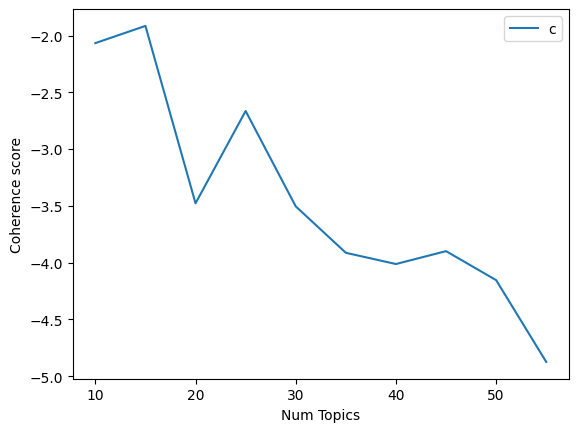

In [5]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
num_topics_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
coherence_scores_list = []
for num_topics in num_topics_list:  
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=5, chunksize=100)
    coherence_score = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_scores_list.append(coherence_score.get_coherence())

# if os.path.isdir(save_path):
#     # save corpus
#     gensim.corpora.MmCorpus.serialize(PATH_CORPUS, corpus)
#     # save dictionary
#     id2word.save(PATH_DICTIONARY)
#     # save lda model
#     lda_model.save(PATH_LDA_MODEL)
# else:
#     os.mkdir(save_path)
#     # save corpus
#     gensim.corpora.MmCorpus.serialize(PATH_CORPUS, corpus)
#     # save dictionary
#     id2word.save(PATH_DICTIONARY)
#     # save lda model
#     lda_model.save(PATH_LDA_MODEL)

# import joblib
# dt_dist = lda_model.get_document_topics(corpus, minimum_probability=0.0)
# dt_dist[:2]
# docs_topics_dist = np.array(
#             [[tup[1] for tup in lst] for lst in dt_dist]
#         )
# # print(docs_topics_dist)
# # save documents-topics matrix
# joblib.dump(docs_topics_dist, PATH_TOPICS_DOCS_DIST)

import matplotlib.pyplot as plt
plt.plot(num_topics_list, coherence_scores_list)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [5]:
lda_model_optimized = LdaModel(corpus=corpus, id2word=id2word, num_topics=15, passes=5, chunksize=100)

In [ ]:
# if os.path.isdir(save_path):
#     # save corpus
#     gensim.corpora.MmCorpus.serialize(PATH_CORPUS, corpus)
#     # save dictionary
#     id2word.save(PATH_DICTIONARY)
#     # save lda model
#     lda_model_optimized.save(PATH_LDA_MODEL)
# else:
#     os.mkdir(save_path)
#     # save corpus
#     gensim.corpora.MmCorpus.serialize(PATH_CORPUS, corpus)
#     # save dictionary
#     id2word.save(PATH_DICTIONARY)
#     # save lda model
#     lda_model_optimized.save(PATH_LDA_MODEL)

In [6]:
lda_model_optimized.print_topics()

[(0,
  '0.033*"việt" + 0.029*"phát_triển" + 0.025*"nam" + 0.020*"việt_nam" + 0.016*"công_nghệ" + 0.016*"quốc_gia" + 0.015*"thủ_tướng" + 0.013*"chủ_tịch" + 0.012*"kinh_tế" + 0.012*"xây_dựng"'),
 (1,
  '0.034*"trận" + 0.029*"world_cup" + 0.025*"ronaldo" + 0.023*"hai" + 0.019*"cầu_thủ" + 0.017*"đội" + 0.017*"thắng" + 0.016*"hlv" + 0.016*"man" + 0.015*"giải"'),
 (2,
  '0.023*"triệu" + 0.020*"du_lịch" + 0.020*"giá" + 0.019*"usd" + 0.019*"đi" + 0.018*"vé" + 0.016*"tour" + 0.014*"đồng" + 0.014*"mua" + 0.013*"phòng"'),
 (3,
  '0.024*"nguyễn" + 0.022*"tp" + 0.016*"tỉnh" + 0.015*"văn" + 0.014*"hai" + 0.013*"bình" + 0.013*"hà_nội" + 0.012*"nam" + 0.012*"hcm" + 0.011*"công_an"'),
 (4,
  '0.025*"trẻ" + 0.023*"đại_học" + 0.015*"học" + 0.014*"trường" + 0.013*"án" + 0.010*"triệu_chứng" + 0.010*"nghiên_cứu" + 0.010*"chấn_thương" + 0.009*"giúp" + 0.008*"giáo_dục"'),
 (5,
  '0.025*"mỹ" + 0.019*"tổng_thống" + 0.011*"ảnh" + 0.009*"video" + 0.009*"tập" + 0.008*"phỏng_vấn" + 0.008*"hai" + 0.008*"quan_hệ" + 0

Phòng khách sạn Thúy Anh ở tại Iceland là những quả cầu pha lê trong suốt, có thể nhìn thấy cả bầu trời sao phía trên đầu.

Hoàng Thúy Anh, Việt kiều Mỹ sống tại bang Texas, có chuyến du lịch 5 ngày tới Iceland hồi cuối hè. Đi cùng chị là người bạn Việt kiều Đức, nhiếp ảnh gia Toni Phạm.

Điều khiến chị Thúy Anh tâm đắc nhất trong chuyến đi lần này là nghỉ đêm tại khách sạn 5 triệu sao (5 Million Star Hotel hay Bubble Hotel), nằm ở miền nam Iceland. "Tôi luôn tìm kiếm các điểm độc đáo ở nơi mình sắp đến và lên kế hoạch ghé thăm. Đó phải là những nơi ít người biết vì tôi thích mạo hiểm, khám phá và luôn muốn giới thiệu đến bạn bè điều mới lạ", Thúy Anh chia sẻ lý do đặt phòng ở khách sạn này.

Căn phòng nơi Thúy Anh ở tại Iceland.

Khách sạn có 12 phòng, được thiết kế như quả cầu pha lê trong suốt, nằm trên một ngọn đồi giữa rừng thông, cách thủ đô Reykjavik khoảng 2 giờ lái xe. Mỗi phòng vừa đủ chỗ kê một chiếc giường đôi, một đèn bàn và chỗ để sạc điện. Nơi này không có wifi, với mục 

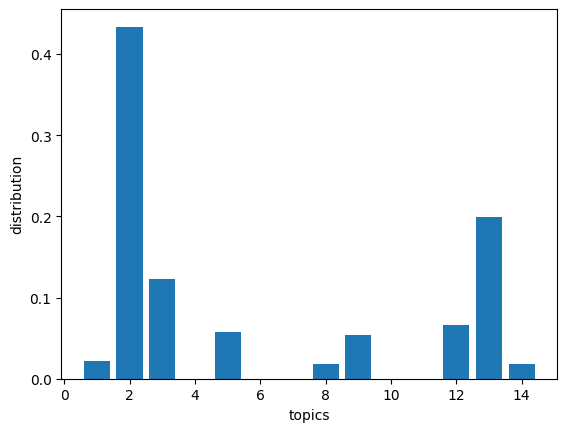

In [11]:
from matplotlib import pyplot as plt
print(data[365][0])
test_doc_bow = id2word.doc2bow(docs_token[365])
test_doc_topics = lda_model_optimized.get_document_topics(test_doc_bow)
topics = [doc_dist[0] for doc_dist in test_doc_topics]
distribution = [doc_dist[1] for doc_dist in test_doc_topics]
plt.bar(topics, distribution)
plt.xlabel('topics')
plt.ylabel('distribution')
plt.show()

In [8]:
test_doc_topics

[(1, 0.021406094),
 (2, 0.43369615),
 (3, 0.1225706),
 (5, 0.058003232),
 (8, 0.018522149),
 (9, 0.053758424),
 (12, 0.065628454),
 (13, 0.19918938),
 (14, 0.018335028)]

In [36]:
import joblib
dt_dist = lda_model.get_document_topics(corpus, minimum_probability=0.0)
dt_dist[:2]
docs_topics_dist = np.array(
            [[tup[1] for tup in lst] for lst in dt_dist]
        )
print(docs_topics_dist)

# save documents-topics matrix
# joblib.dump(docs_topics_dist, PATH_TOPICS_DOCS_DIST)


[[1.85324233e-02 1.83476999e-01 1.83573502e-04 ... 1.83573502e-04
  1.83573502e-04 1.83573502e-04]
 [1.28303946e-04 4.33120355e-02 1.28303946e-04 ... 1.28303946e-04
  1.28303946e-04 1.28303946e-04]
 [1.02623766e-04 2.06170991e-01 1.02623766e-04 ... 1.02623766e-04
  1.02623766e-04 1.02623766e-04]
 ...
 [2.08364232e-04 3.47809456e-02 2.08364232e-04 ... 6.34641126e-02
  2.08364232e-04 4.06194739e-02]
 [8.33491504e-04 8.33491504e-04 8.33491504e-04 ... 8.33491504e-04
  8.33491504e-04 1.55016467e-01]
 [5.25184587e-05 5.25184587e-05 5.25184587e-05 ... 5.25184587e-05
  4.15883213e-02 5.25184587e-05]]


In [27]:
item_dist = [[tup[1] for tup in doc_dist] for doc_dist in lda_model[corpus]]

In [19]:
[len(doc_dist) for doc_dist in item_dist]

[9,
 8,
 7,
 9,
 12,
 5,
 7,
 12,
 8,
 10,
 3,
 11,
 6,
 14,
 12,
 14,
 8,
 10,
 15,
 14,
 6,
 7,
 3,
 7,
 9,
 17,
 6,
 8,
 6,
 11,
 4,
 7,
 8,
 8,
 16,
 8,
 13,
 10,
 7,
 7,
 8,
 12,
 8,
 7,
 8,
 12,
 11,
 9,
 14,
 9,
 8,
 8,
 12,
 4,
 9,
 9,
 8,
 11,
 14,
 9,
 7,
 13,
 12,
 10,
 5,
 14,
 7,
 8,
 10,
 7,
 12,
 5,
 8,
 5,
 2,
 3,
 7,
 7,
 8,
 5,
 11,
 10,
 13,
 15,
 8,
 5,
 6,
 13,
 12,
 10,
 16,
 14,
 9,
 1,
 14,
 10,
 11,
 13,
 8,
 5,
 50,
 2,
 8,
 10,
 6,
 15,
 8,
 9,
 3,
 4,
 8,
 7,
 10,
 8,
 12,
 11,
 13,
 6,
 8,
 7,
 13,
 10,
 11,
 5,
 7,
 5,
 14,
 8,
 8,
 9,
 10,
 7,
 3,
 6,
 8,
 6,
 5,
 13,
 6,
 8,
 8,
 6,
 10,
 11,
 7,
 5,
 12,
 7,
 9,
 4,
 12,
 9,
 6,
 8,
 11,
 7,
 8,
 10,
 3,
 13,
 9,
 5,
 9,
 17,
 7,
 9,
 16,
 5,
 10,
 17,
 7,
 8,
 11,
 6,
 7,
 10,
 2,
 5,
 10,
 4,
 13,
 13,
 6,
 13,
 7,
 4,
 11,
 9,
 15,
 9,
 2,
 5,
 14,
 12,
 13,
 10,
 7,
 4,
 11,
 6,
 3,
 6,
 10,
 10,
 12,
 10,
 9,
 8,
 4,
 7,
 9,
 4,
 6,
 3,
 7,
 7,
 7,
 7,
 10,
 4,
 2,
 6,
 7,
 7,
 7,
 8,
 7,
 6,
 11,


In [23]:
docs_topics_dist = lda_model.get_document_topics(corpus, minimum_probability=0.0)
print(docs_topics_dist[0])

[(0, 0.00015664446), (1, 0.00015664446), (2, 0.00015664446), (3, 0.14611824), (4, 0.00015664446), (5, 0.00015664446), (6, 0.00015664446), (7, 0.068384126), (8, 0.00015664446), (9, 0.00015664446), (10, 0.00015664446), (11, 0.00015664446), (12, 0.00015664446), (13, 0.00015664446), (14, 0.00015664446), (15, 0.00015664446), (16, 0.00015664446), (17, 0.00015664446), (18, 0.00015664446), (19, 0.018986873), (20, 0.00015664446), (21, 0.00015664446), (22, 0.020576175), (23, 0.00015664446), (24, 0.00015664446), (25, 0.00015664446), (26, 0.07081053), (27, 0.00015664446), (28, 0.00015664446), (29, 0.00015664446), (30, 0.55614895), (31, 0.00015664446), (32, 0.00015664446), (33, 0.00015664446), (34, 0.00015664446), (35, 0.03936303), (36, 0.05692358), (37, 0.00015664446), (38, 0.00015664446), (39, 0.00015664446), (40, 0.00015664446), (41, 0.00015664446), (42, 0.00015664446), (43, 0.00015664446), (44, 0.00015664446), (45, 0.00015664446), (46, 0.00015664446), (47, 0.00015664446), (48, 0.016266108), (49

In [26]:
topics_dist_docs_matrix = [[tup[1] for tup in topics_dist_doc] for topics_dist_doc in docs_topics_dist]

[50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
